* 1.调试中遇到的最大的问题花费时间最长的是嵌入层变量是tf.random_uniform([embedding_matrix.shape[0], embedding_size], -0.25, 0.25)就没有问题，直接填写自训练好的就不行。
* 2.dropout_keep_prob在训练集上可以设置调参，但是在验证集和测试集的时候就要设置成1。
* 3.attention选用的是静态Attention。

In [ ]:
#import initial

import numpy as np
import pandas as pd
import numpy  as np
import tensorflow as tf

train_ids_pad_path = 'RE_Data/train_ids_pad.npy'
test_ids_pad_path = 'RE_Data/test_ids_pad.npy'
dev_ids_pad_path = 'RE_Data/dev_ids_pad.npy'

embedding_matrix_path = 'RE_Data/embedding_matrix.npy'
pos1_embedding_path = 'RE_Data/pos1_embedding.npy'
pos2_embedding_path = 'RE_Data/pos2_embedding.npy'

en1pos_train_path = 'RE_Data/en1pos_train.npy'
en2pos_train_path = 'RE_Data/en2pos_train.npy'
en1pos_test_path = 'RE_Data/en1pos_test.npy'
en2pos_test_path = 'RE_Data/en2pos_test.npy'
en1pos_dev_path = 'RE_Data/en1pos_dev.npy'
en2pos_dev_path = 'RE_Data/en2pos_dev.npy'

train_label_path = 'RE_Data/train_label.npy'
dev_label_path = 'RE_Data/dev_label.npy'


# 保存标签
train_ids_pad = np.load(train_ids_pad_path)
test_ids_pad = np.load(test_ids_pad_path)
dev_ids_pad = np.load(dev_ids_pad_path)
'''
en1pos_train = np.load(en1pos_train_path)
en2pos_train = np.load(en2pos_train_path)
en1pos_test = np.load(en1pos_test_path)
en2pos_test = np.load(en2pos_test_path)
en1pos_dev = np.load(en1pos_dev_path)
en2pos_dev = np.load(en2pos_dev_path)
'''
y_train = np.load(train_label_path)
y_dev = np.load(dev_label_path)

embedding_matrix = np.load(embedding_matrix_path)
print(train_ids_pad.shape)
print(y_train.shape)
print(embedding_matrix.shape)
print("load ok...")
'''
pos1_embedding = np.load(pos1_embedding_path)
pos2_embedding = np.load(pos2_embedding_path)
'''
#参数定义
max_sentence_length = 70
embedding_size = 300
pos_num = 123
pos_size = 5
l2_reg_lambda = 1e-5
lr = 0.1
nepoch = 1
batch_size = 1024
hidden_size = 100
num_classes = 35
clip = 5
isTrain = True

graph = tf.Graph()
with graph.as_default():
    """
    构建神经网络的结构、损失、优化方法和评估方法
    """
    #模型搭建
    input_text = tf.placeholder(tf.int32, shape=[None, max_sentence_length], name='input_text')
    input_y = tf.placeholder(tf.float32, shape=[None, num_classes], name='input_y')
    emb_dropout_keep_prob = tf.placeholder(tf.float32, name='emb_dropout_keep_prob')
    rnn_dropout_keep_prob = tf.placeholder(tf.float32, name='rnn_dropout_keep_prob')
    dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

    initializer = tf.keras.initializers.glorot_normal

    # Word Embedding Layer
    with tf.variable_scope("word-embeddings"):
        W_text = tf.Variable(tf.random_uniform([embedding_matrix.shape[0], embedding_size], -0.25, 0.25),trainable = 'False',name="W_text")
        embedded_vec = tf.nn.embedding_lookup(W_text, input_text)
        print(embedded_vec)
    # Dropout for Word Embedding
    with tf.variable_scope('dropout-embeddings'):
        embedded_output = tf.nn.dropout(embedded_vec, emb_dropout_keep_prob)
        print(embedded_output)
    # Bidirectional LSTM
    with tf.variable_scope("bi-lstm"):
        _fw_cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
        fw_cell = tf.nn.rnn_cell.DropoutWrapper(_fw_cell, rnn_dropout_keep_prob)
        _bw_cell = tf.nn.rnn_cell.LSTMCell(hidden_size)
        bw_cell = tf.nn.rnn_cell.DropoutWrapper(_bw_cell, rnn_dropout_keep_prob)
        #(rnn_outputs_fw_seq, rnn_outputs_bw_seq), states = tf.nn.bidirectional_dynamic_rnn(cell_fw=fw_cell,cell_bw=bw_cell,inputs=embedded_output,dtype=tf.float32)					
        (rnn_outputs_fw_seq, rnn_outputs_bw_seq), states = tf.nn.bidirectional_dynamic_rnn(fw_cell, bw_cell,
            embedded_output,dtype=tf.float32)
        print(rnn_outputs_fw_seq.shape)
        print(rnn_outputs_bw_seq.shape)

        rnn_outputs = tf.add(rnn_outputs_fw_seq, rnn_outputs_bw_seq)
        print(rnn_outputs.shape)
    # Attention
    with tf.variable_scope('attention'):
        def attention(inputs):
            # Trainable parameters
            hidden_size = inputs.shape[2].value
            u_omega = tf.get_variable("u_omega", [hidden_size], initializer=tf.keras.initializers.glorot_normal())

            with tf.name_scope('v'):
                v = tf.tanh(inputs)

            # For each of the timestamps its vector of size A from `v` is reduced with `u` vector
            vu = tf.tensordot(v, u_omega, axes=1, name='vu')  # (B,T) shape
            alphas = tf.nn.softmax(vu, name='alphas')  # (B,T) shape

            # Output of (Bi-)RNN is reduced with attention vector; the result has (B,D) shape
            output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), 1)

            # Final output with tanh
            output = tf.tanh(output)

            return output, alphas
        attn, alphas = attention(rnn_outputs)

    # Dropout
    with tf.variable_scope('dropout'):
        h_drop = tf.nn.dropout(attn,dropout_keep_prob)

    # Fully connected layer
    with tf.variable_scope('output'):
        logits = tf.layers.dense(h_drop, num_classes, kernel_initializer=initializer())
        predictions = tf.argmax(logits, 1, name="predictions")

    # Calculate mean cross-entropy loss
    with tf.variable_scope("loss"):
        losses = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=input_y)
        l2 = tf.add_n([tf.nn.l2_loss(v) for v in tf.trainable_variables()])
        loss = tf.reduce_mean(losses) + l2_reg_lambda * l2

    #选择优化器
    with tf.variable_scope("train_step"):
        global_step = tf.Variable(0, name="global_step", trainable=False)
        global_add = global_step.assign_add(1)#用于计数
        optim = tf.train.AdamOptimizer(learning_rate=lr)
        grads_and_vars = optim.compute_gradients(loss)
        # 对梯度gradients进行裁剪，保证在[-clip, clip]之间。
        grads_and_vars_clip = [[tf.clip_by_value(g, -clip, clip), v] for g, v in grads_and_vars]
        train_op = optim.apply_gradients(grads_and_vars_clip, global_step=global_step)

    # Accuracy
    with tf.variable_scope("accuracy"):
        correct_predictions = tf.equal(predictions, tf.argmax(input_y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name="accuracy")

def get_batch(x_train,y_train,batch_size):
    for i in range((x_train.shape[0]) // batch_size):
        s = x_train[i * batch_size: (i + 1) * batch_size]
        y = y_train[i * batch_size: (i + 1) * batch_size]
        yield s,y

def to_one_hot(labels, tag_nums):
    length = len(labels)#batch的样本个数
    res = np.zeros((length, tag_nums), dtype=np.int32)
    for i in range(length):
        res[i][labels[i]] = 1.0
    return np.array(res)

with tf.Session(graph=graph) as sess:
    if isTrain:
        saver = tf.train.Saver(tf.global_variables())
        try:
            ckpt_path = tf.train.latest_checkpoint('checkpoint/')
            saver.restore(sess, ckpt_path)
        except ValueError:
            init = tf.global_variables_initializer()
            sess.run(init)
        best_acc = 0.0 
        for epoch in range(nepoch):
            print('第%s轮训练' % str(epoch+1))
            for s,y in get_batch(train_ids_pad,y_train,batch_size):
                feed_dict = {
                    input_text: s,
                    input_y: y,
                    emb_dropout_keep_prob: 0.7,
                    rnn_dropout_keep_prob: 0.7,
                    dropout_keep_prob : 0.5,
                }
                _, l,acc, global_nums= sess.run([train_op,loss,accuracy,global_add], feed_dict)
                if global_nums % 30 == 0:#每30个batch保存一次
                    print('train:epoch {}, global_step {}, loss: {:.4}, acc: {:.4}'.format(epoch + 1, global_nums + 1, l, acc))
            
            print('第%s轮验证' % str(epoch+1))
            #验证集上测试效果
            for s,y in get_batch(dev_ids_pad,y_dev,batch_size):
                feed_dict = {
                    input_text: s,
                    input_y: y,
                    emb_dropout_keep_prob: 1.0,
                    rnn_dropout_keep_prob: 1.0,
                    dropout_keep_prob : 1.0,
                }
                acc_d= sess.run([accuracy],feed_dict)
                if best_acc < acc_d[0]:
                    best_acc = acc_d[0]
                    path = saver.save(sess, './checkpoint/' + "model-{:.3g}.ckpt".format(best_acc), global_step=global_nums)
                    print("Saved model checkpoint to {}\n".format(path))
                    print('dev:epoch {}, global_step {}, loss: {:.4}, acc: {:.4}'.format(epoch + 1, global_nums + 1, l, acc_d[0]))


服务器上运行的截图：

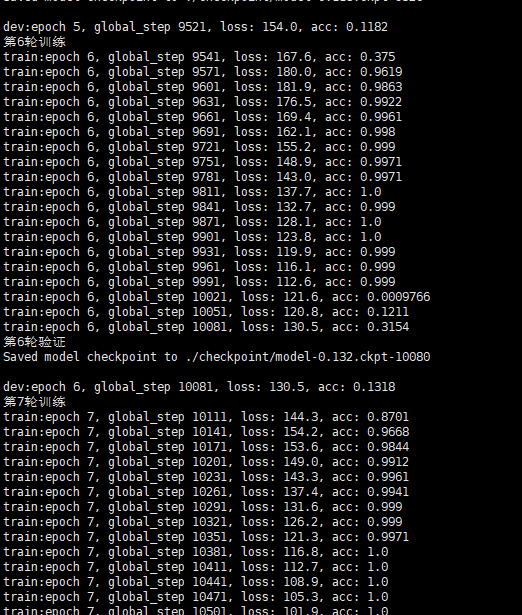